# What waveforms can tell us about induced seismic sources<br/>

In this notebook, we look into the so-called *moment tensor* (MT) description of a seismic source. The moment tensor is a three by three tensor containing six independent parameters. **Moment tensor representations of seismic sources are particulary useful because they linearise the *forward problem* of seismic wave excitation.** Furthermore assuming the most simple subsurface (homogeneous, isotropic and losslesss), we consider moment tensors associated with specific source characteristics and investigate the resulting waveforms at the Earth's surface. The assumptions regarding the medium imply that the so-called Green's functions, which contain the subsurface' response to a point source, can be computed analytically knowing the density, P-wave velocity, and S-wave velocity of the subsurface.


<!--The analytical Green's displacement vector due to a (moment tensor) point source in such a medium is explicitly derived in Aki & Richards (2002) and given in equation 4.29. The investigation of the different sampling strategies focussses on so-called Piecewise deterministic Processes (PDPs). -->

## The forward problem

In the context of induced seismicity, time-dependent surface displacement is generally recorded by arrays of three-component surface seismometers. Let us denote the recorded surface displacement by $\mathbf{u}$ (a vector quantity) and the seismometer location by $\mathbf{x}$. Assuming the displacement to be accurate at periods for which the induced seismic source is effectively a point source, $\mathbf{u}$ can be expressed as a temporal convolution between the spatial derivative (with respect to the source coordinates $\boldsymbol{\xi}=(\xi_1,\xi_2,\xi_3)$) of the elastic *Green's function* $\mathbf{G}$ and the moment tensor $\mathbf{M}$. Mathematically, this can be written as
$$
u_{n}(\mathbf{x},t)=\sum_{p=1}^{3} \sum_{j=1}^{3} G_{n p, j}(\mathbf{x},t;\boldsymbol{\xi}^{(0)},0) * M_{p j}(\boldsymbol{\xi}^{(0)},t),
$$
where the subscripts $n$, $p$ and $j$ take on values 1, 2, or 3 and are associated with the $x_1$, $x_2$ and $x_3$ coordinate axes. The comma denotes spatial differentiation. Often, a local geographic coordinate system is used to define a Cartesian system tensor, with positive $x_1$ being northward, positive $x_2$ eastward, and positive $x_3$ being downward (NED). <!--Above, Einstein's summation convention applies and hence the right-hand side contains an implicit summation over 9 components of the moment tensor.-->

### The Green's function

Although often referred to as the Green's "function", the wavefield at $\mathbf{x}$ due to an impulsive source at $\boldsymbol{\xi}^{(0)}$ is effectively represented by a nine-component tensor: for each of the unidirectional impulsive (delta function) forces (one in each of the three Cartesian directions) at $\boldsymbol{\xi}^{(0)}$, the wavefield at $\mathbf{x}$ has three components ($u_1$, $u_2$, and $u_3$). **A medium's Green's function captures all wave-propagation related physics between source and receiver.** Obviously, an accurate velocity model is required in order to accurately compute Green's functions. Inaccurate velocity models can be a major limitation when it comes to seismic source characterization. 

<br>
<center>
    <figure style="width700px;">
        <img src="greens_function.png"/>
        <figcaption><i>Example of a Green's function computed for the velocity model below Groningen. The impulsive source is is located at the left and the wavefield is (in this case) "recorded" in the middle of the Groningen gas reservoir</i></figcaption>
    </figure>
</center>



### Moment magnitude

We mentioned above that at sufficiently long periods, a seismic source can be represented by a so-called moment tensor. The moment tensor description of a seismic source effectively collapses this source to a single point in the subsurface (point source assumption). The moment tensor is symmetric, and hence has six independent elements. The so-called *scalar moment* provides an estimate of the strenght of a seismic source (Silver & Jordan, 1982):
$$
M_{0} \equiv \sqrt{\sum_{i=1}^{3} \sum_{j=1}^{3} M_{ij}^{2}}/\sqrt{2}
$$

Importantly, Kanamori (1977) based a magnitude scale on the seismic moment of an earthquake. This magnitude is referred to as the *moment magnitude*, and is usually denoted by $M_W$. It is the only physics-based earthquake magnitude scale and therefore fundamentally different from empirical magnitude scales such as Richter's magnitude scale (which is usually referred to as the local magnitude and denoted by $M_L$). The moment magnitude is related to $M_0$ by (Kanamori, 1977),
$$
log(M_0) = 1.5 M_W + 9.1.
$$


### Strike, dip, and rake

Often, a local geographic coordinate system is used to define a Cartesian system tensor, with positive $x_1$ being northward, positive $x_2$ eastward, and positive $x_3$ being downward (NED). The NED coordinate system is used below to derive relations between the angles of a ruptured fault (strike and dip angle) and the dislocation direction on the rupture plane (rake angle). The strike, dip, and rake are denoted by $\varphi$, $\delta$, and $\lambda$, respectively, and are defined as follows:
* Strike ($\varphi$) is defined as the clockwise angle of the fault from North (positive $x_1$)
* Dip ($\delta$) is defined as the angle with the horizontal plane, in a direction 90 degrees clockward of strike.
* Rake ($\lambda$) gives the direction of relative displacement along fault and is defined as the angle, counterclockwise, with respect to the strike. 0 < rake < 180 therefore means that the there is a component of thrust faulting, whereas -180 < rake < 0 implies a component of normal faulting

<center>
    <figure style="width:600px;">
        <img src="strike_dip_rake.png"/>
        <figcaption><i>Example of an oblique thrust fault with a strike of 90 degrees. </i></figcaption>
    </figure>
</center>



<br><span style="font-size:1.5em;">*Import all necessary modules*</span>

In [1]:
# Please run it before you start the simulation!
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
from numpy import sin, cos, arccos, arctan,  pi, sign, sqrt
from numpy import vectorize, linspace, asarray, outer, diff, savetxt
import pandas as pd
pd.set_option('display.float_format', '{:.3g}'.format)
from pyproj import CRS, Transformer
from pyrocko import moment_tensor as pmt
from pyrocko import util
from pyrocko.plot import beachball
from pyrocko import plot
from scipy.special import erf
from scipy.integrate import quad

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import io
from urllib.request import urlopen, Request
from PIL import Image

#from mpl_toolkits.basemap import Basemap
#import warnings



<br><span style="font-size:1.5em;">*Setting the stage*</span>

In [2]:
# Moment Magnitude of the earthquake(Mw)
magnitude = 0.16 

# Orientation of the fault and direction of slip
strike = 0       # Strike is defined as the clockwise angle of the fault from North (positive x1)
dip = 80     # Dip is defined as the angle with the horizontal plane, 
                 # in a direction 90 degrees clockward of strike.
rake = -90      # Rake gives the direction of relative displacement along fault and defined as the 
                 # angle, counterclockwise, with respect to the strike. 0 < rake < 180 therefore means
                 # that the there is a component of thrust faulting, whereas -180 < rake < 0 implies
                 # a component of normal faulting

# Source time function
#stf = 'gauss'             # Set the desired source time function 'heaviside' , 'gauss error function'
Trise = 0.01              # Rise time used in the source time function 

# Medium parameters
rho = 2500                # Density kg/m^3 
beta = 1200               # S-wave velocity
alpha = sqrt(3)*beta      # p-wave velocity

<br><span style="font-size:1.5em;">*Precompute variables*</span>

In [3]:
# Convert moment magnitude to moment based on Kanamori (1977); See Aki & Richards, eq. 3.17
M0=10**(1.5*magnitude+9.1)  

# Compute moment tensor components from strike, dip, rake and scalar moment
mt = pmt.MomentTensor(strike=strike, dip=dip, rake=rake, scalar_moment=M0)

m6 = [mt.mnn, mt.mee, mt.mdd, mt.mne, mt.mnd, mt.med]  # The six MT components
#print(m6/mt.scalar_moment())  # normalized MT components
### Define here the moment tensor
MOMT=np.zeros((3, 3))
MOMT[0,0]=mt.mnn/mt.scalar_moment()
MOMT[1,1]=mt.mee/mt.scalar_moment()
MOMT[2,2]=mt.mdd/mt.scalar_moment()
MOMT[0,1]=mt.mne/mt.scalar_moment()
MOMT[1,0]=mt.mne/mt.scalar_moment()
MOMT[0,2]=mt.mnd/mt.scalar_moment()
MOMT[2,0]=mt.mnd/mt.scalar_moment()
MOMT[1,2]=mt.med/mt.scalar_moment()
MOMT[2,1]=mt.med/mt.scalar_moment()

# Source time function times seismic moment 
stf = lambda t: M0*((1 + erf(t/Trise))/2)

# Calculate integrand of near-field term
integrand = lambda  tau, t: tau*stf(t - tau)

# Evaluate integral of near-field term
def integral(t, r):
    return quad(integrand, r/alpha, r/beta, args=(t))[0]

vec_integral = vectorize(integral)

<br><span style="font-size:1.5em;">*Moment tensor and focal mechanism (beach ball)*</span>

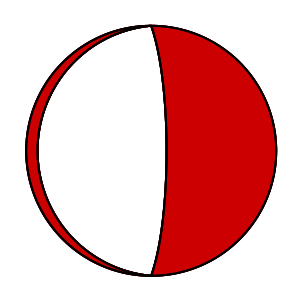

Moment tensor values:


,"$M_{1,j}$","$M_{2,j}$","$M_{3,j}$"
"$M_{i,1}$",0,6.03e-17,-1.06e-17
"$M_{i,2}$",6.03e-17,0.342,0.94
"$M_{i,3}$",-1.06e-17,0.94,-0.342


In [4]:
fig = plt.figure(figsize=(4., 4.))
fig.subplots_adjust(left=0., right=1., bottom=0., top=1.)
axes = fig.add_subplot(1,1,1)
axes.set_xlim(0., 2.)
axes.set_ylim(0., 2.)
axes.set_axis_off()

beachball.plot_beachball_mpl(
            pmt.as_mt(mt),
            axes,
            beachball_type='full',
            size=250.,
            position=(1, 1),
            color_t=plot.mpl_color('scarletred2'),
            linewidth=2.0)
plt.show()

print("Moment tensor values:")
Moment_Tensor = pd.DataFrame(MOMT, 
                             columns=['$M_{1,j}$','$M_{2,j}$','$M_{3,j}$'],
                             index=['$M_{i,1}$','$M_{i,2}$','$M_{i,3}$'],
                            )
display(Moment_Tensor)

<br><span style="font-size:1.5em;">*Assignment 2: Seismic waveforms*</span>

Last year, Aardwamte Combinatie Luttelgeest drilled a total of three wells for the purpose of heating a number of greenhouses. For the purpose of monitoring geothermal production, a local seismic array consisting of 13 geophones was installed in the area. In this assignment we will simulate a specific seismic event and analyze the signals (recordings of surface displacemnt). Mind that Green's functios are computed assuming a uniform subsurface having the density, P-wave velocity, and S-wave velocity defined above. In the following figure the seismic array and the location of the three geothermal wells can be seen.

In [15]:
station_file = "/Volumes/kwintsheul/Delft-GT/Network.csv"
borehole_file = "/Volumes/kwintsheul/Delft-GT/Delft_GT.csv"

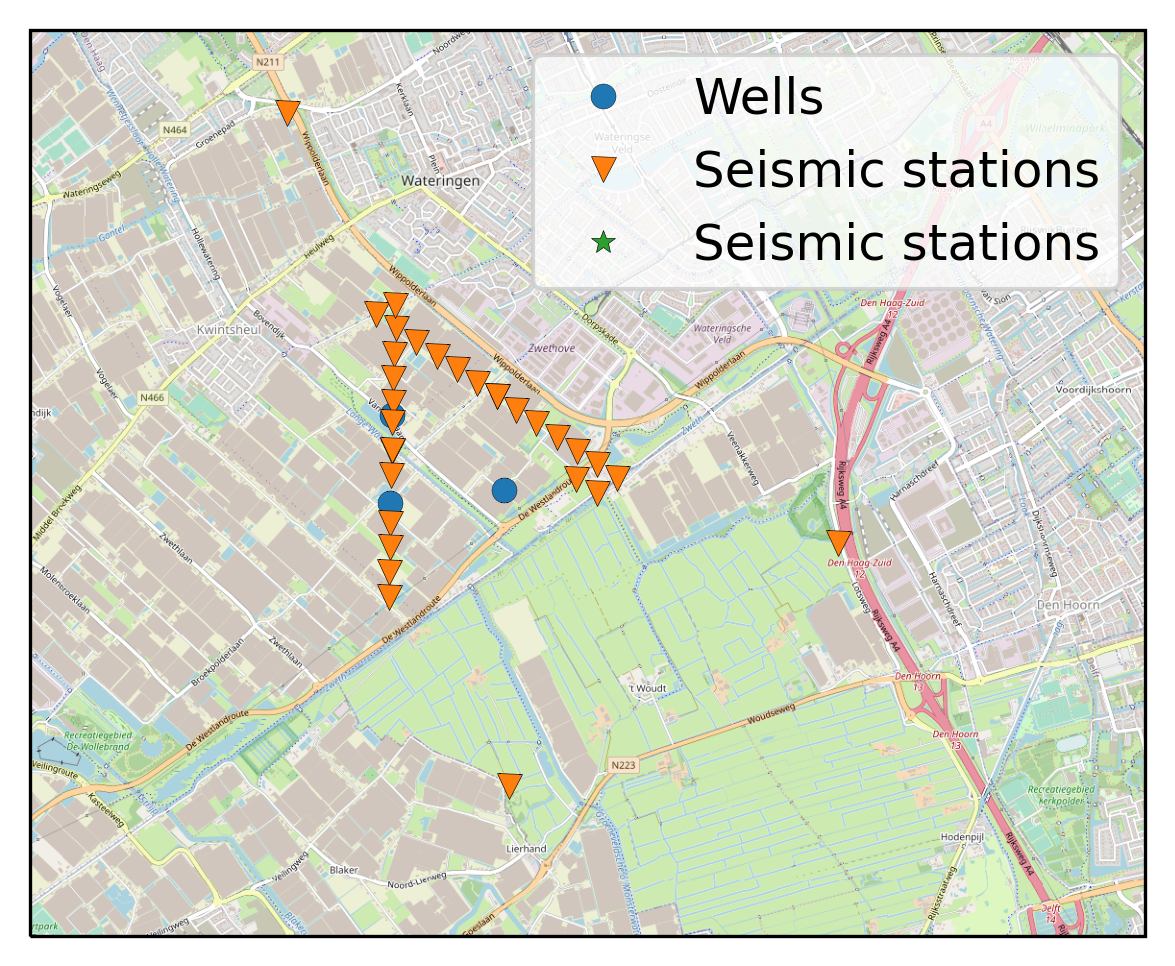

In [24]:

def image_spoof(self, tile): # this function pretends not to be a Python script
    url = self._image_url(tile) # get the url of the street map API
    req = Request(url) # start request
    req.add_header('User-agent','Anaconda 3') # add user agent to request
    fh = urlopen(req) 
    im_data = io.BytesIO(fh.read()) # get image
    fh.close() # close url
    img = Image.open(im_data) # open image with PIL
    img = img.convert(self.desired_tile_form) # set image format
    return img, self.tileextent(tile), 'lower' # reformat for cartopy

cimgt.OSM.get_image = image_spoof # reformat web request for street map spoofing
osm_img = cimgt.OSM() # spoofed, downloaded street map

fig = plt.figure(dpi=300)
ax1 = plt.axes(projection=osm_img.crs) # project using coordinate reference system (CRS) of street map
center_pt = [52.0068, 4.2878]  # lat/lon of EQ
zoom = 0.025 # for zooming out of center point
extent = [center_pt[1]-(zoom*2.0),center_pt[1]+(zoom*2.0),center_pt[0]-zoom,center_pt[0]+zoom] # adjust to zoom
ax1.set_extent(extent) # set extents

scale = np.ceil(-np.sqrt(2)*np.log(np.divide(zoom,350.0))) # empirical solve for scale based on zoom
scale = (scale<20) and scale or 19 # scale cannot be larger than 19
ax1.add_image(osm_img, int(scale)) # ad

### Read and plot borehole locations
boreholes = pd.read_csv(borehole_file)
lons_bo = list(boreholes["X"])
lats_bo = list(boreholes["Y"])
codes_bo = list(boreholes["Name"])
ax1.plot(lons_bo, lats_bo, marker="o",markeredgewidth=0.1, markeredgecolor='k', linestyle='',label="Wells", transform=ccrs.PlateCarree())

### Read and plot seismic station locations
inv = pd.read_csv(station_file)
lons = list(inv["X"])
lats = list(inv["Y"])
codes = list(inv["Name"])
ax1.plot(lons, lats, marker="v", markeredgewidth=0.15, markeredgecolor='k',linestyle='',label="Seismic stations", transform=ccrs.PlateCarree())

# Seismic event
ax1.plot(52.0068, 4.2878, marker="*", markeredgewidth=0.15, markeredgecolor='k',linestyle='',label="Seismic stations", transform=ccrs.PlateCarree())
plt.legend(fontsize=12)
plt.show()

In [41]:
### The following five functions return the radiation patterns 
### of near (UN), intermediate (UIP, UIS), and far (UFP,UFS) field terms of the Green's function
### Scalar factors in solution of Aki & Richards (Eq. 4.29)

def compGN(gamma):
    GN= np.zeros((3, 3, 3))
    for i in range(3):
        for j in range(3):
            for k in range(3):
                GN[i,j,k] = 15*gamma[i]*gamma[j]*gamma[k]
                if i==j:
                    GN[i,j,k]=GN[i,j,k] - 3*gamma[k]
                if i==k:
                    GN[i,j,k]=GN[i,j,k] - 3*gamma[j]
                if j==k:
                    GN[i,j,k]=GN[i,j,k] - 3*gamma[i]
    return asarray(GN)


#################################################################################################
def compGIP(gamma):
    GIP = np.zeros((3, 3, 3))
    for i in range(3):
        for j in range(3):
            for k in range(3):
                GIP[i,j,k] = 6*gamma[i]*gamma[j]*gamma[k]
                if i==j:
                    GIP[i,j,k]=GIP[i,j,k] - gamma[k]
                if i==k:
                    GIP[i,j,k]=GIP[i,j,k] - gamma[j]
                if j==k:
                    GIP[i,j,k]=GIP[i,j,k] - gamma[i]
    return asarray(GIP)


#################################################################################################
def compGIS(gamma):
    GIS = np.zeros((3, 3, 3))
    for i in range(3):
        for j in range(3):
            for k in range(3):
                GIS[i,j,k] = 6*gamma[i]*gamma[j]*gamma[k]
                if i==j:
                    GIS[i,j,k]=GIS[i,j,k] - 2*gamma[k]
                if i==k:
                    GIS[i,j,k]=GIS[i,j,k] - gamma[j]
                if j==k:
                    GIS[i,j,k]=GIS[i,j,k] - gamma[i]
    return asarray(GIS)


#################################################################################################
def compGFP(gamma):
    GFP = np.zeros((3, 3, 3))
    for i in range(3):
        for j in range(3):
            for k in range(3):
                GFP[i,j,k] = gamma[i]*gamma[j]*gamma[k]
    return asarray(GFP)


#################################################################################################
def compGFS(gamma):
    GFS = np.zeros((3, 3, 3))
    for i in range(3):
        for j in range(3):
            for k in range(3):
                GFS[i,j,k] = gamma[i]*gamma[j]*gamma[k]
                if i==j:
                    GFS[i,j,k]=GFS[i,j,k] - gamma[k]
    return asarray(GFS)


#################################################################################################
def calculate_seismic_waveform(r_n, r_e, r_z, s_n, s_e, s_z):
    '''
    Function to calculate the synthetic waveform of an event located at 
    s_z, s_n, s_e recorded at a receiver located at r_z, r_n, r_e.
    Coordinates should cartesian.
    
    returns
    --------
    U:
        Three vecotrs with the North, East, and Vertical component (last one is positive downward)
    t: 
        time vector
    r: 
        Distance from hypocenter.
    '''
       
    r_n = r_n - s_n
    r_e = r_e - s_e
    r_z = r_z - s_z
    #print(r_n,r_e,r_z)
    
    # Distance
    r = sqrt(r_n**2 + r_e**2 + r_z**2)

    # Directional cosines
    gamma = [r_n/r, r_e/r, r_z/r]

    # Scalar factors in solution of Aki & Richards (Eq. 4.29; also eq. 4.32)
    prefactor = 1/(4 * pi * rho)
    CN  = prefactor/(r**4) 
    CIP = prefactor/(alpha**2 * r**2)
    CIS = prefactor/(beta**2 * r**2)
    CFP = prefactor/(alpha**3 * r)
    CFS = prefactor/(beta**3 * r)


    GN = compGN(gamma)
    UN = np.zeros(3)
    for i in range(3):
            for j in range(3):
                UN[0]=UN[0]+GN[0,i,j]*MOMT[i,j]
                UN[1]=UN[1]+GN[1,i,j]*MOMT[i,j]
                UN[2]=UN[2]+GN[2,i,j]*MOMT[i,j]

    GIP = compGIP(gamma)
    UIP = np.zeros(3)
    for i in range(3):
            for j in range(3):
                UIP[0]=UIP[0]+GIP[0,i,j]*MOMT[i,j]
                UIP[1]=UIP[1]+GIP[1,i,j]*MOMT[i,j]
                UIP[2]=UIP[2]+GIP[2,i,j]*MOMT[i,j]

    GIS = compGIS(gamma)
    UIS = np.zeros(3)
    for i in range(3):
            for j in range(3):
                UIS[0]=UIS[0]+GIS[0,i,j]*MOMT[i,j]
                UIS[1]=UIS[1]+GIS[1,i,j]*MOMT[i,j]
                UIS[2]=UIS[2]+GIS[2,i,j]*MOMT[i,j]

    GFP = compGFP(gamma)
    UFP = np.zeros(3)
    for i in range(3):
            for j in range(3):
                UFP[0]=UFP[0]+GFP[0,i,j]*MOMT[i,j]
                UFP[1]=UFP[1]+GFP[1,i,j]*MOMT[i,j]
                UFP[2]=UFP[2]+GFP[2,i,j]*MOMT[i,j]

    GFS = compGFS(gamma)
    UFS = np.zeros(3)
    for i in range(3):
            for j in range(3):
                UFS[0]=UFS[0]+GFS[0,i,j]*MOMT[i,j]
                UFS[1]=UFS[1]+GFS[1,i,j]*MOMT[i,j]
                UFS[2]=UFS[2]+GFS[2,i,j]*MOMT[i,j]

    # Multiplication with prefactors
    UN=CN*UN
    UIP=CIP*UIP
    UIS=CIS*UIS 
    UFP=CFP*UFP
    UFS=CFS*UFS


    # Minimum and maximum observation time 
    tmin = r/alpha - 2*Trise
    tmax = r/beta + Trise + 2*Trise  

    t = linspace(tmin, tmax, 2000)
    UNt=outer(UN,vec_integral(t,r))
    UIPt = outer(UIP,stf(t-r/alpha))
    UISt = outer(UIS,stf(t-r/beta))

    t, dt = linspace(tmin, tmax, 2001, retstep=True)
    UFPt = outer(UFP, diff(stf(t - r/alpha))/dt)
    UFSt = outer(UFS, diff(stf(t - r/beta))/dt)

    t = linspace(tmin, tmax, 2000)
    # U = UNt + UIPt - UISt + UFPt - UFSt
    U = UFPt - UFSt  ## Near and intermediate field contributions neglected (for workshop only)

    return U, t, r


In [42]:

def plot_waveforms(data, U):
    """
    Function to plot recordings by all stations on all components as function of epicentral distance
    """
    
    plt.rcParams["font.family"] = "serif"
    plt.rcParams.update({'font.size': 24})  
    fig = plt.figure(figsize=(20,10),dpi = 300,constrained_layout=True)
    gs  = fig.add_gridspec(1, 3) # three components -> 3 subplots
    max_t=1.2  # latest time plotted


    ax1 = fig.add_subplot(gs[0,0])
    ax1.title.set_text('N Component')
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.set_xlabel('Time since event [s]')
    ax1.set_ylabel('Epicentral distance (m)')
    ax1.set_xlim(0,max_t)

    ax2 = fig.add_subplot(gs[0,1])
    ax2.title.set_text('E Component')
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.set_xlabel('Time since event [s]')
   
    ax2.set_xlim(0,max_t)
    
    ax3 = fig.add_subplot(gs[0,2])
    ax3.title.set_text('Z Component')
    ax3.spines['right'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    ax3.set_xlabel('Time since event [s]')
    ax3.set_xlim(0,max_t)

    font = {'family': 'serif', 'color':  'darkgreen', 'weight': 'normal', 'size': 20}

    cmap = plt.cm.seismic
    norm = matplotlib.colors.Normalize(vmin=1, vmax=len(data))
    
    ## Sort stations from west to east for purpose of color coding
    east_srtd = sorted(data, key=lambda x: (data[x]['east']))    
    i=0
    for station in east_srtd:
        i+=1  
        data[station]['color'] = cmap(norm(i))
        #print(station,data[station]['east'])

    max_N=np.amax(abs(U[:,0,:]))
    max_E=np.amax(abs(U[:,1,:]))
    max_NE=max(max_N,max_E)
    max_Z=np.amax(abs(U[:,2,:]))
    
    #epic_srtd = sorted(data, key=lambda x: (data[x]['epic']))   ## Sort as function of epicentral distance
    #for station in epic_srtd:
    for station in data:

        print('Plot (in background) recordings by station ' + str(station) + ' at epicentral distance of ' + str(data[station]['epic']) + ' meter' )
        
        ax1.plot([0,data[station]['t'][0]],[0+data[station]['epic'],0+data[station]['epic']],'-',linewidth=3,color=data[station]['color'])
        ax1.plot(data[station]['t'],1000*U[data[station]['index'],0,:]/max_NE + data[station]['epic'],'-',linewidth=3,color=data[station]['color'])
        ax1.plot([data[station]['t'][len(data[station]['t'])-1],max_t],[0+data[station]['epic'],0+data[station]['epic']],'-',linewidth=3,color=data[station]['color'])
     
        ax2.plot([0,data[station]['t'][0]],[0+data[station]['epic'],0+data[station]['epic']],'-',linewidth=3,color=data[station]['color'])
        ax2.plot(data[station]['t'],1000*U[data[station]['index'],1,:]/max_NE + data[station]['epic'],'-',linewidth=3,color=data[station]['color'])
        ax2.plot([data[station]['t'][len(data[station]['t'])-1],max_t],[0+data[station]['epic'],0+data[station]['epic']],'-',linewidth=3,color=data[station]['color'])
    
        ax3.plot([0,data[station]['t'][0]],[0+data[station]['epic'],0+data[station]['epic']],'-',linewidth=3,color=data[station]['color'])
        ax3.plot(data[station]['t'],200*U[data[station]['index'],2,:]/max_Z + data[station]['epic'],'-',linewidth=3,color=data[station]['color'])
        ax3.plot([data[station]['t'][len(data[station]['t'])-1],max_t],[0+data[station]['epic'],0+data[station]['epic']],'-',linewidth=3,color=data[station]['color'])

    ## Sort stations with epicentral distance to determine ylim
    epic_srtd = sorted(data, key=lambda x: (data[x]['epic']))   
    ax1.set_ylim(0,data[epic_srtd[len(epic_srtd)-1]]['epic']+100)
    ax1.set_yticks(np.arange(0,data[epic_srtd[len(epic_srtd)-1]]['epic']+100,100))
    ax2.set_ylim(0,data[epic_srtd[len(epic_srtd)-1]]['epic']+100)
    ax2.set_yticks(np.arange(0,data[epic_srtd[len(epic_srtd)-1]]['epic']+100,10000)) # prevents annotations
    ax3.set_ylim(0,data[epic_srtd[len(epic_srtd)-1]]['epic']+100)
    ax3.set_yticks(np.arange(0,data[epic_srtd[len(epic_srtd)-1]]['epic']+100,10000)) # prevents annotations

    plt.show()  

    return(data)


#################################################################################################
def plot_stations(data,s_lon,s_lat):
    '''
    Function to plot station locations and beachball 
   
    '''
    
    fig = plt.figure(dpi=300)
    
    ax1 = plt.axes(projection=osm_img.crs) # project using coordinate reference system (CRS) of street map
    zoom = 0.005 # for zooming out of center point
    extent = [s_lon-(zoom*2.5),s_lon+(zoom*3.0),s_lat-zoom,s_lat+zoom] # adjust to zoom
    ax1.set_extent(extent) # set extents

    scale = np.ceil(-np.sqrt(2)*np.log(np.divide(zoom,350.0))) # empirical solve for scale based on zoom
    scale = (scale<20) and scale or 19 # scale cannot be larger than 19
    ax1.add_image(osm_img, int(scale)) # ad

   
    ### Read and plot seismic station locations
    for station in data:         
        ax1.plot(data[station]['lon'],data[station]['lat'],marker="v",markeredgewidth=0.5, markeredgecolor='k',color=data[station]['color'], linestyle='', transform=ccrs.PlateCarree())

    ax1.plot(s_lon,s_lat,c="yellow", marker=(5, 1),markersize=20, markeredgewidth=2, markeredgecolor='k',linestyle='', transform=ccrs.PlateCarree())

    beachball.plot_beachball_mpl(
                pmt.as_mt(mt),
                axes,
                beachball_type='full',
                size=30.,
                position=(s_lon, s_lat),
                color_t=plot.mpl_color('scarletred2'),
                linewidth=1.0, zorder=4)

    plt.show()
    
    return()

# Synthetic waveforms recorded by seismic array over geothermal reservoir


Plot (in background) recordings by station 1 at epicentral distance of 150.04035164302255 meter
Plot (in background) recordings by station 2 at epicentral distance of 932.5268175901057 meter
Plot (in background) recordings by station 6 at epicentral distance of 707.609709557055 meter
Plot (in background) recordings by station 7 at epicentral distance of 704.1560281006313 meter
Plot (in background) recordings by station 8 at epicentral distance of 421.46149901660567 meter
Plot (in background) recordings by station 9 at epicentral distance of 290.4957163009983 meter
Plot (in background) recordings by station 10 at epicentral distance of 416.1689517884275 meter
Plot (in background) recordings by station 11 at epicentral distance of 241.22771878369417 meter
Plot (in background) recordings by station 12 at epicentral distance of 224.90345737807823 meter
Plot (in background) recordings by station 15 at epicentral distance of 244.87633902353298 meter
Plot (in background) recordings by station

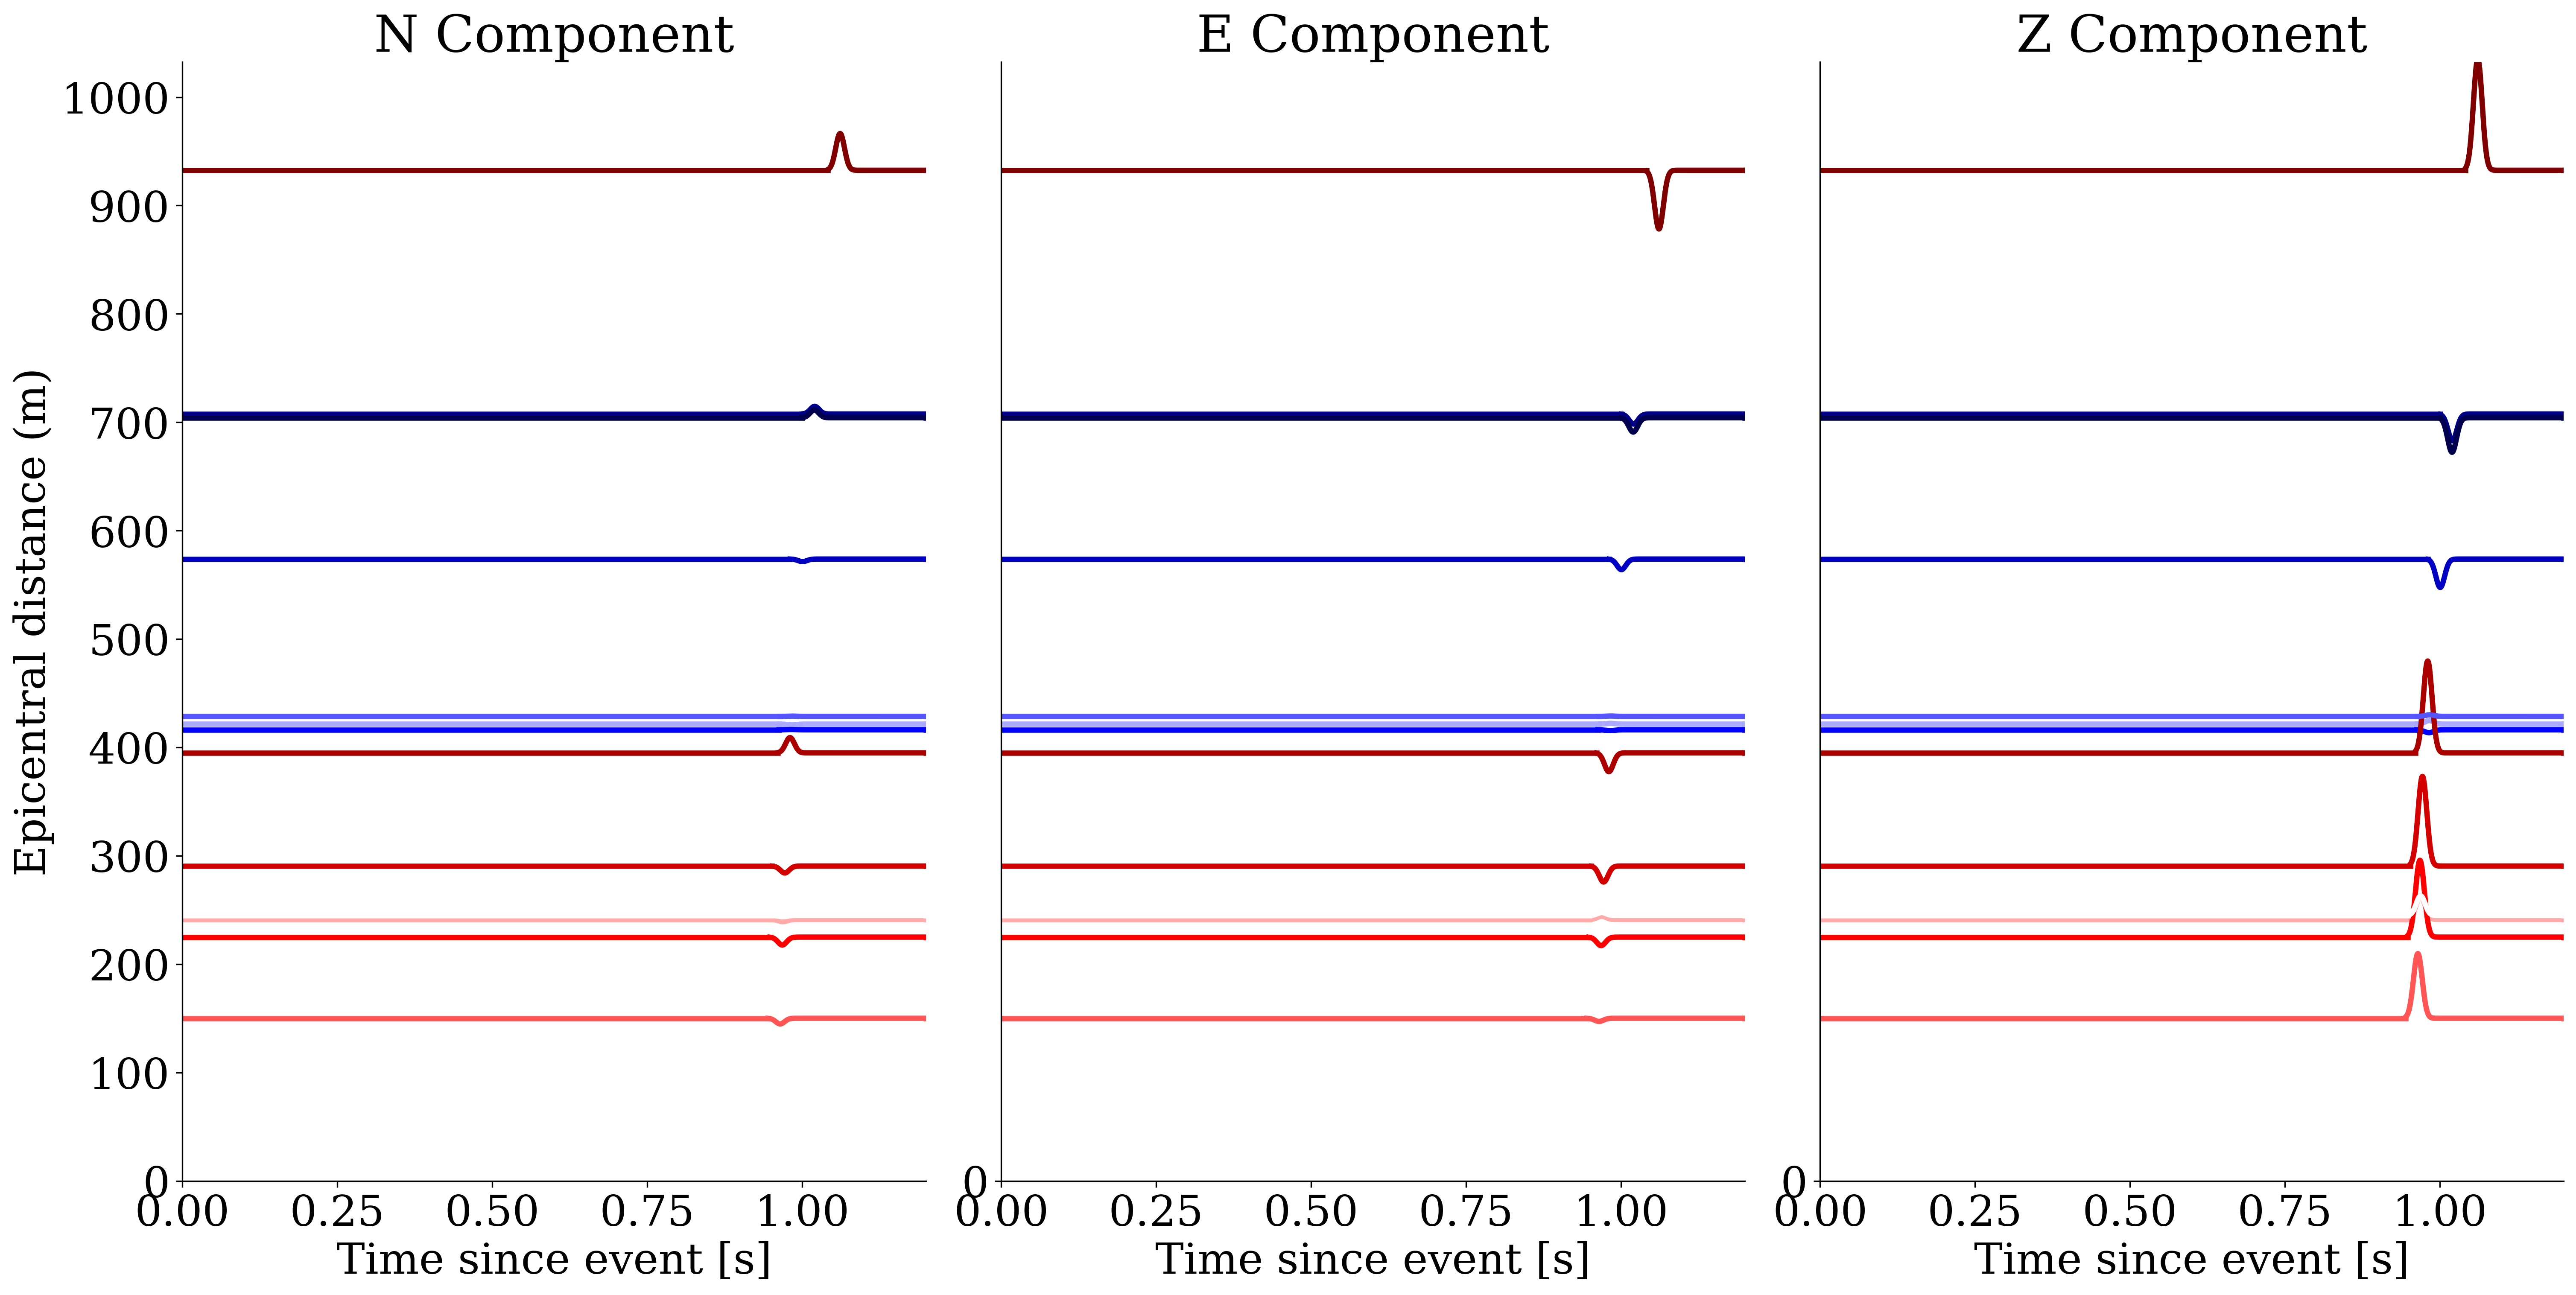

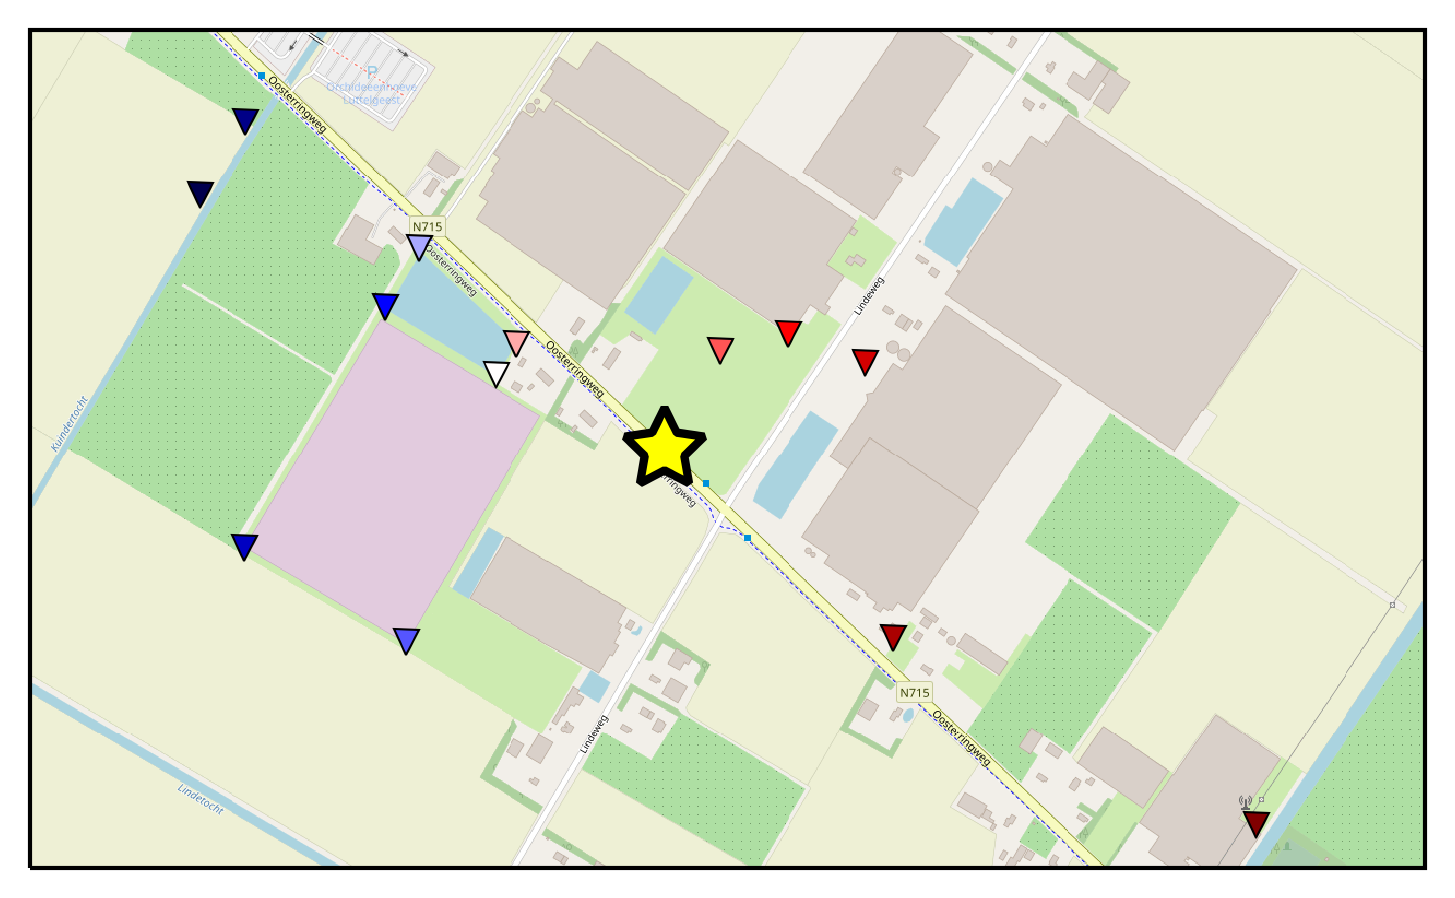

()

In [43]:
# Read Luttelgeest station coordinates
inv = pd.read_csv("Luttelgeest_wgs84.csv")
lons = list(inv["longitude"])
lats = list(inv["latitude"])
codes = list(inv["Station_code"])

# initalize function to convert lat-lon RD coordinates.
crs_latlon = CRS("EPSG:4326")  
crs_amersfoort = CRS("EPSG:28992")
transformer = Transformer.from_crs(crs_latlon, crs_amersfoort)

# Depth of event (meters)
s_z = 2000
# Epicenter in latitude, longitude
s_lat, s_lon = 52.753, 5.84225
# Epicenter in RD coordinates
s_e, s_n =transformer.transform(s_lat, s_lon)

# Depth of the seismic stations
r_z = 0
# Station locations in RD coordinates
r_e, r_n =transformer.transform(lats, lons)

# Initialize both matrix containing all waveforms and dictionary
U_all = np.zeros((len(codes),3,2000))
data={}

# Loop over seismic stations to compute waveforms 
for i in range(len(codes)):
    #print(i, codes[i],r_e[i],r_n[i])   
    U_all[i,:,:], t, r = calculate_seismic_waveform(r_n[i], r_e[i], r_z, s_n, s_e, s_z)
    
    data[codes[i]]={}
    data[codes[i]]['index'] =i
    data[codes[i]]['lat'] = lats[i]
    data[codes[i]]['lon'] = lons[i]
    data[codes[i]]['north'] = r_n[i]
    data[codes[i]]['east'] = r_e[i]
    data[codes[i]]['epic'] = sqrt((r_e[i]-s_e)**2 + (r_n[i]-s_n)**2)
    data[codes[i]]['r'] = r
    data[codes[i]]['t'] = t 

# Plot recordings by all stations on all components as function of epicentral distance
data = plot_waveforms(data, U_all)

# Plot recordings by all stations on all components as function of epicentral distance
plot_stations(data,s_lon,s_lat)

